In [18]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='imgs10'
fps = 10

image_files = sorted([os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")])[:50]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('50_firsts.mp4')

Moviepy - Building video 50_firsts.mp4.
Moviepy - Writing video 50_firsts.mp4



Moviepy - Done !
Moviepy - video ready 50_firsts.mp4


# -------------------------------------

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, opening, closing
import glob

In [71]:
frames = []
for img in sorted(glob.glob("imgs_samples/*.jpg")):
    frames.append(cv2.imread(img))

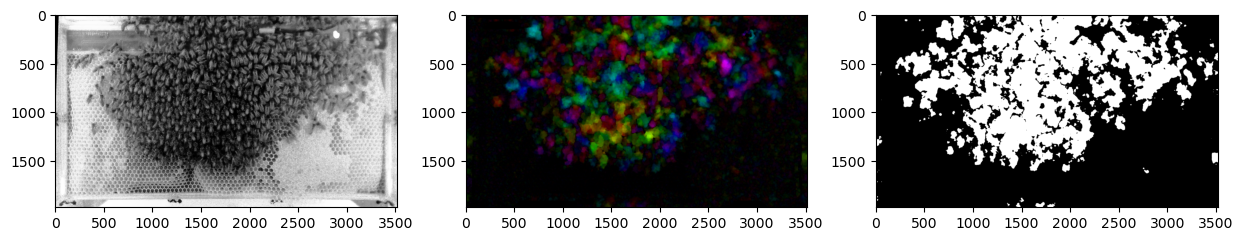

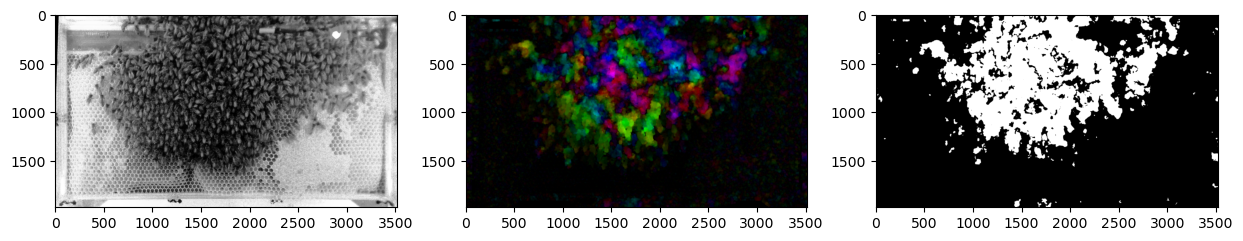

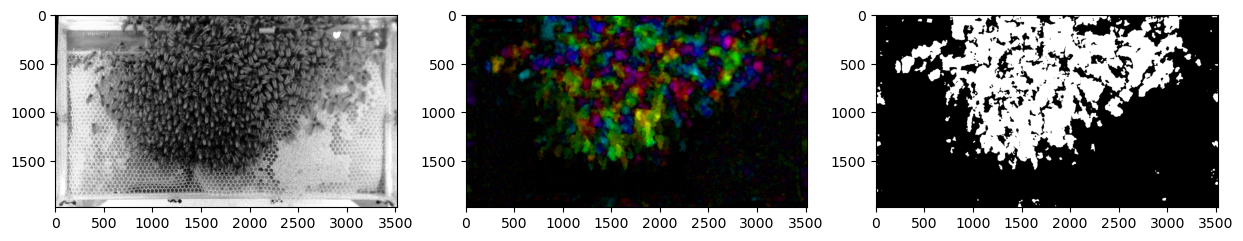

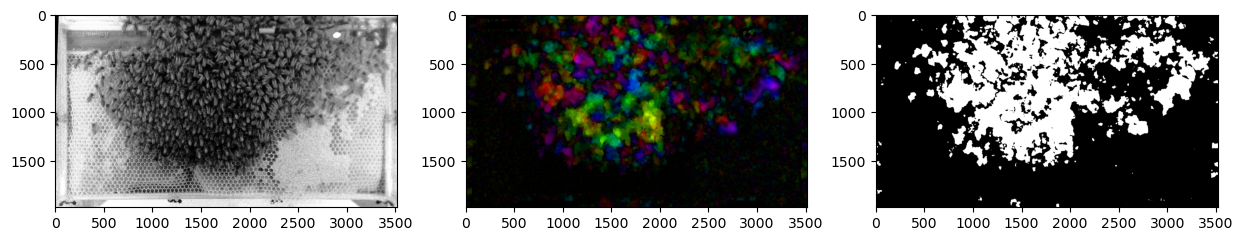

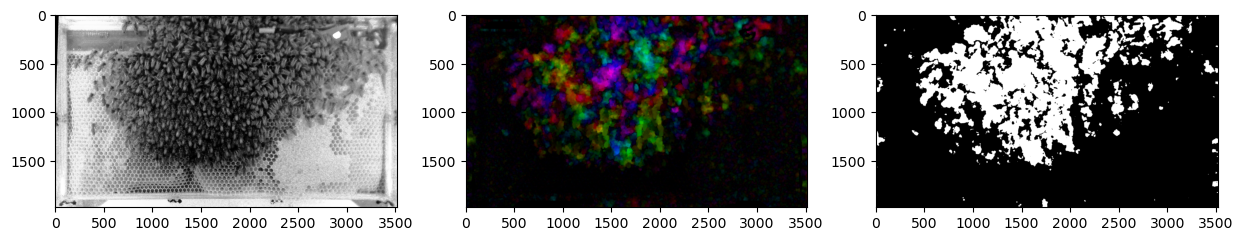

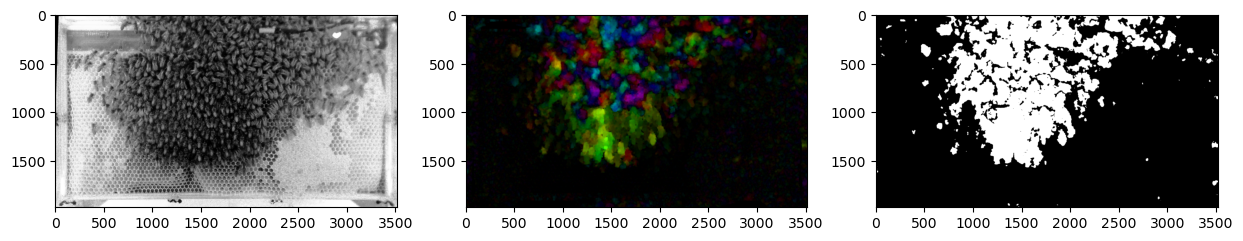

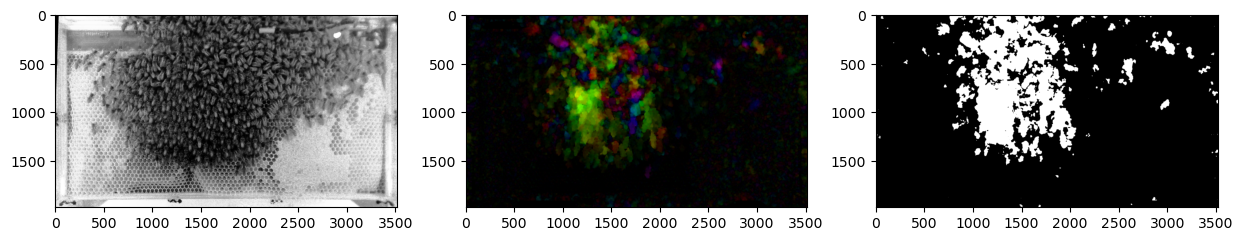

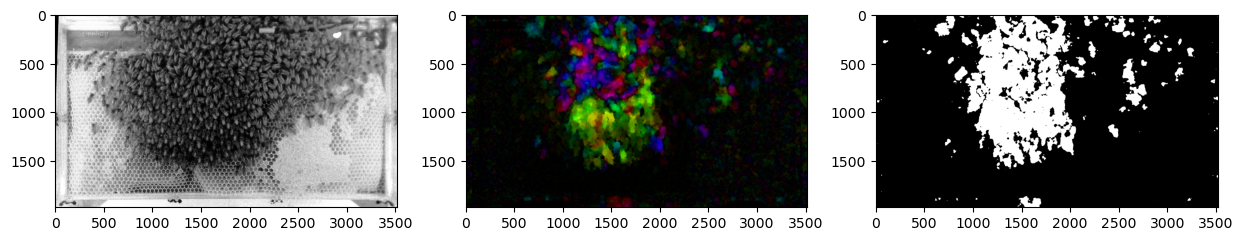

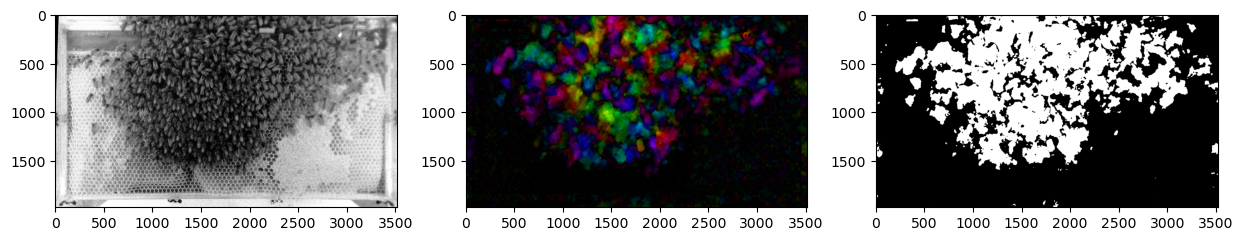

In [57]:
masks = []

n = 0
for frame in frames:
    if n == 0:
        prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(frames[0])
        mask[..., 1] = 255
        n += 1
        continue

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        
    # Calculates dense optical flow by Farneback method 
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, flow=None, 
                                        pyr_scale=0.5, # PyrScale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one. default 0.5.
                                        levels=3,      # Number of pyramid layers including the initial image. Levels=1 means that no extra layers are created and only the original images are used. default 5.
                                        winsize=15,    # Averaging window size. Larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field. default 13.
                                        iterations=3,  # Number of iterations the algorithm does at each pyramid level. default 10.
                                        poly_n=5,      # Size of the pixel neighborhood used to find polynomial expansion in each pixel. Larger values mean that the image will be approximated with smoother surfaces, yielding more robust algorithm and more blurred motion field. Typically, PolyN is 5 or 7. default 5.
                                        poly_sigma=1.2,# Standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion. For PolyN=5, you can set PolySigma = 1.1. For PolyN=7, a good value would be PolySigma = 1.5. default 1.1.
                                        flags=0)
        
    # Computes the magnitude and angle of the 2D vectors 
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
        
    # Sets image hue according to the optical flow  
    # direction 
    mask[..., 0] = angle * 180 / np.pi / 2
        
    # Sets image value according to the optical flow 
    # magnitude (normalized) 
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    thresh_val = 7.5
    _, thresholded_mask = cv2.threshold(magnitude, thresh_val, 255, cv2.THRESH_BINARY)

    ax[1].imshow(cv2.cvtColor(mask, cv2.COLOR_HSV2RGB))
    ax[2].imshow(thresholded_mask, cmap='gray')

    masks.append(thresholded_mask)
    plt.show()
    prev_gray = gray
    n += 1



In [72]:
# morphology
masks_closed = []
for mask in masks:
    mask_open = opening(mask, disk(9))
    mask_closed = closing(mask_open, disk(9))
    masks_closed.append(mask)

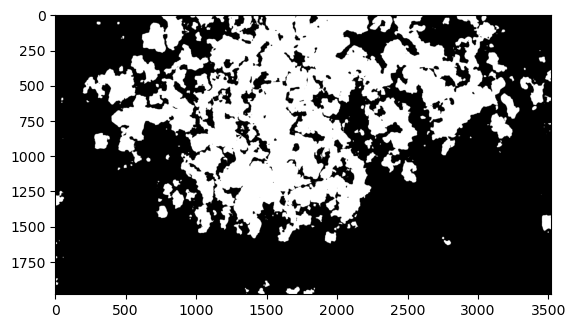

In [73]:
# mask_open = opening(mask[0], disk(15))
# mask_closed = closing(mask_open, disk(15))
plt.imshow(masks_closed[0], cmap='gray')
plt.show()

In [74]:
print(len(masks_closed))


9


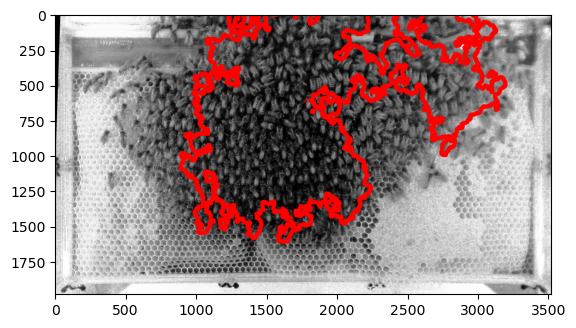

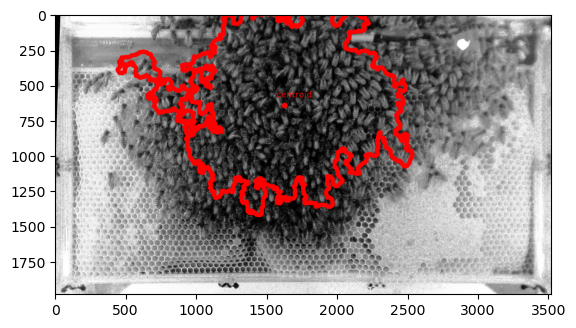

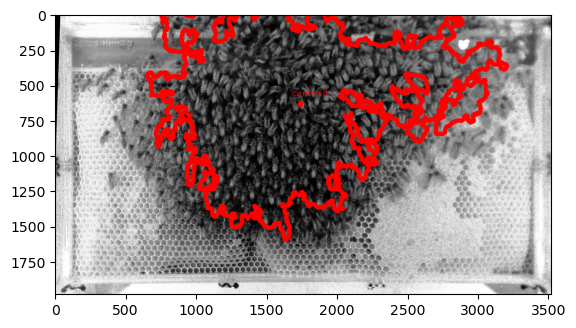

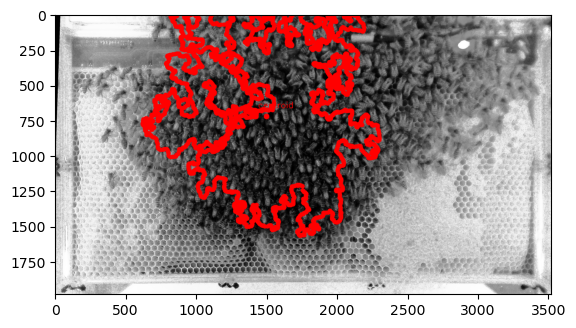

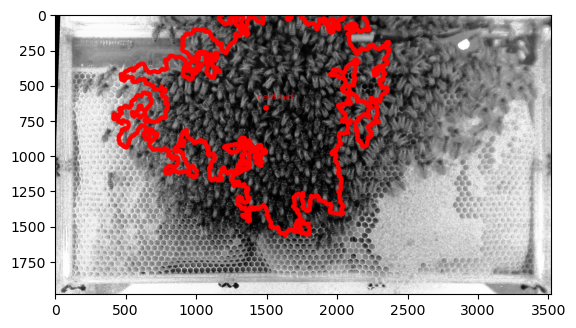

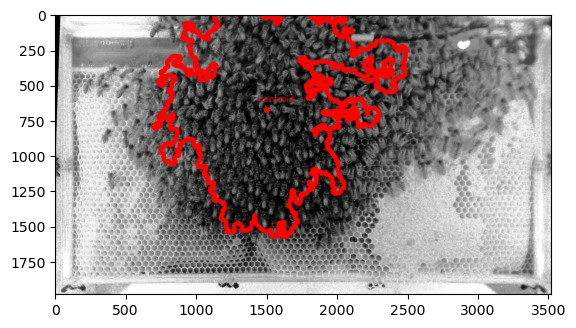

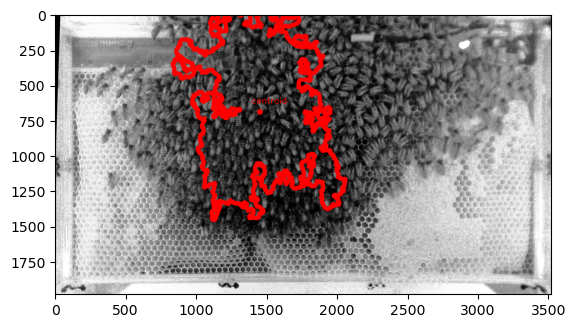

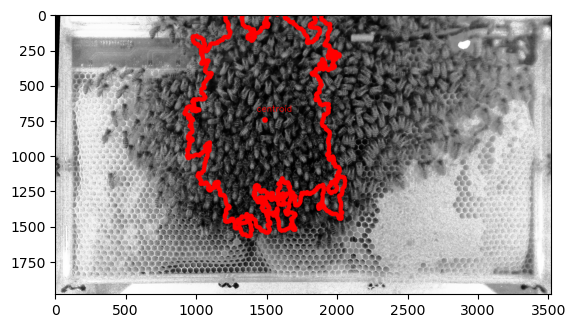

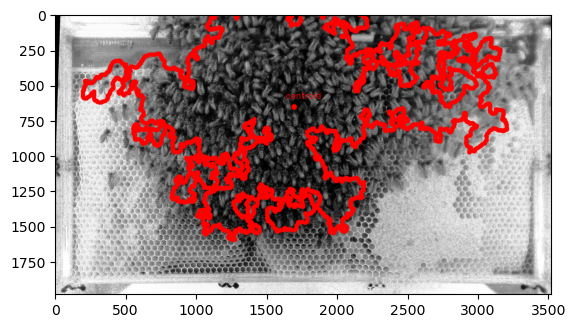

In [75]:
# find the contours

# now we can find the contours
for mask_closed, input_image in zip(masks_closed, frames[1:]):
    img_contour = (mask_closed).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
    contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    contour = max(contours, key=cv2.contourArea) #get the biggest contour
    img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
    cv2.drawContours(input_image, contour, -1, (255, 0, 0), 30) #draw the biggest contour

    # find the centroid of the contour
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # plot it on the image
    cv2.circle(input_image, (cX, cY), 20, (255, 0, 0), -1)
    cv2.putText(input_image, "centroid", (cX - 60, cY - 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4);

    plt.imshow(input_image)
    plt.show()